# Hands-on Machine Learning
# Chapter 4 - Training Models

## Setup

In [66]:
# Is Python version at least 3.5?
import sys
assert sys.version_info >= (3, 5)

# Is sklearn at least version 0.2?
import sklearn
assert sklearn.__version__  >= "0.20"

# Helper libraries
import numpy as np
import pandas as pd

# Matplotlib setup 
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore warnings for this notebook
import warnings
warnings.filterwarnings(action='ignore', message='^internal gelsd')

In [67]:
# Directory for storing images
import os
PROJECT_ROOT_DIR = "../"
CHAPTER_ID = '04_training_linear_models'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

In [68]:
# Function save images
def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print("Saving figure ", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Example 1 - Normal Equation and Linear Models
The normal equation provides a closed-form solution for minimising the parameter values $\theta$ of a linear model to minimise the mean square error between the model's predictions $y'$ and $y$.

In [11]:
np.random.seed(42)

In [12]:
# Create a domain of 100 random values between 0 and 1
X = 2 * np.random.rand(100, 1)

# Use this domain to create a linear sum with some normally distributed noise
y = 4 + 3 * X + np.random.randn(100, 1)

Saving figure  01_generated_data_plot


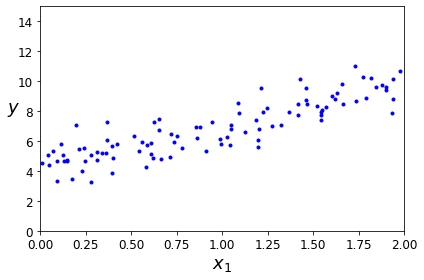

In [13]:
# Create a scatter plot of the randomly generated data
plt.plot(X, y, 'b.')
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$y$', rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15]) # Axis limits
save_fig('01_generated_data_plot')

Will now compute the values of $\theta$ for this dataset using the normal equation to prove that it does, indeed, derive the correct values. `np.linalg.inv` is used to invert the matrix and `dot` is used for matrix multiplication in the evaluation of  $$\theta^{'} = (X^{T}X)^{-1}X^{T}y$$

In [14]:
# Add the bias feature x_0 = 1 to all rows in X
X_b = np.c_[np.ones((100, 1)), X]

In [15]:
# Use the normal equation to find the values of theta for this model
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [16]:
theta_best

array([[4.21509616],
       [2.77011339]])

The reason why the normal equation does not predict exactly 4 and 3 is because we have added random noise to the value computed by the original function.

In [17]:
# Create new instances on which to test the normal equation
X_new = np.array([[0], [2]])

# Add x_0 = 1 to each instance
X_new_b = np.c_[np.ones((2, 1)), X_new] 

# Make predictions
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

Saving figure  02_linear_model_predictions_plot


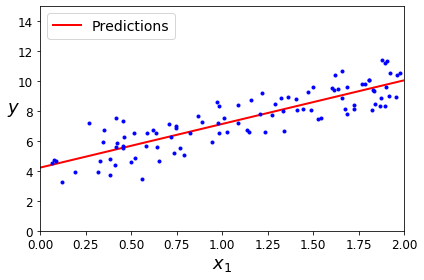

In [23]:
# Plot the model's predictions for all values in the domain
plt.plot(X_new, y_predict, 'r-', label='Predictions', linewidth=2)

# Original scatterplot data
plt.plot(X, y, 'b.')

plt.axis([0, 2, 0, 15])
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$y$', fontsize=18, rotation=0)
plt.legend(loc='upper left', fontsize=14)
save_fig('02_linear_model_predictions_plot')
plt.show()

## Example 2 - Linear Regression with `sklearn`

In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
lin_reg = LinearRegression()

In [20]:
# Computes the values of theta_0 and theta_1 that minimise MSE for X
lin_reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [21]:
# Output the learnt params 
print("Intercept: ", lin_reg.intercept_)
print("Coefficients: ", lin_reg.coef_)

Intercept:  [4.21509616]
Coefficients:  [[2.77011339]]


In [22]:
# Make predictions on new data using the linear regression model
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

 Under the hood, the `LinearRegression.fit()` method calls the least squares minimising function built into `scipy`, which we can call directly. It returns the least squares solution to a linear matrix equation.

In [23]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)

In [24]:
theta_best_svd

array([[4.21509616],
       [2.77011339]])

Gives the same results as the linear regression function, but at a lower level of abstraction. Also, doesn't compute the inverse, but rather the pseudoinverse of X. The equation it solves is $$\theta^{'} = X^{+}y$$ where $X^{+}$ is the pseudoinverse of $X$.

In [25]:
# Can compute pseudoinverse and its dot product with y directly
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

### Pseudoinverse vs Inverse
Pseudoinverse computation is done using **singular value decomposition (SVD)**, which decomposes a training set matrix **X** into the multiplication of three matrices $U$, $\Sigma$, $V^{T}$. 

The pseudoinverse uses $X^{+} = V \Sigma^{+}U^{T}$. To compute $Sigma^+$, the algorithm will set to 0 all values in $\Sigma$ that are lower than a specified threshold. Non-zero values are replaced with their inverses. The resulting matrix is then transposed. 

This provides a more **computationally efficient approach** than computing the actual inverse as in the normal equation, and also handles edge cases very wel. 

## Batch Gradient Descent

In [87]:
eta = 0.1         # Learning rate
n_iterations = 1000    # Number of steps until convergence assumed
m = 100           # Number of training samples in the batch 

In [88]:
theta = np.random.randn(2, 1) # Random initialisation of weights

In [89]:
for iteration in range(n_iterations):
    # Computing the gradient using entire batch - bias feature x_0 = 1 included
    gradients = 2 / m * X_b.T.dot(X_b.dot(theta) - y) 
    
    # Updating parameters by moving in the direction of steepest descent
    theta = theta - eta * gradients

In [90]:
theta

array([[4.21509616],
       [2.77011339]])

Gives the same values for `theta_0` and `theta_` as the linear regression model we implemented earlier (both with `sklearn` and with normal equation).

In [91]:
# Predictions made for a new data point will also be the same as earlier
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

## How does learning rate affect BGD?

Showing the first 10 steps of gradient descent with different learning rates. Updates values of theta, and then uses those values to plot a straight line at each step.

In [92]:
theta_path_bgd = []

In [93]:
def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b) # Number of features
    plt.plot(X, y, 'b.') # Scatterplot of training samples
    n_iterations = 100
    
    # At every iteration
    for iteration in range(n_iterations):
        # For the first 10 iterations
        if iteration < 10:
            # Make predictions using the last updated values of theta
            y_predict = X_new_b.dot(theta)
            
            # The first prediction will be shown as a red line
            style = 'b-' if iteration > 0 else 'r--'
            
            # All other predictions will be shown as blue lines
            plt.plot(X_new, y_predict, style)
            
        # Compute the gradient for the next update of theta
        gradients = 2 / m * X_b.T.dot(X_b.dot(theta) - y)
        
        # Update theta
        theta = theta - eta * gradients
        
        # If there are already some values in theta_path, append the new theta updated values to it
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel('$x_1$', fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r'$\eta = {}$'.format(eta), fontsize=16)

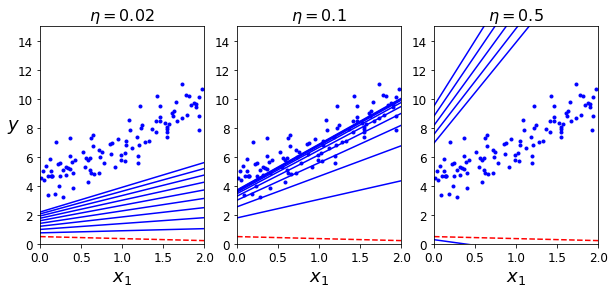

In [94]:
np.random.seed(42)
theta = np.random.randn(2, 1)
plt.figure(figsize=(10, 4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel('$y$', rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5);

The first plot shows what happens when the learning rate is too low: the model will probably converge to the right values of theta, but will take too many iterations to do so.

The second plot shows what happens when the learning rate is "just right": it has already converged to the scatterplot in 10 iterations.

When the learning rate is too large (as in the third plot), the model actually diverges: it moves farther away from the scatterplot at each iteration.

Because the author knew that the optimal values of theta would be obtained with a learning rate of 0.1, he has chosen to save the values of theta with learning rate = 0.1 in `theta_path_bgd` so that they can be plotted later on.

## How to set iterations?
- Specify a very large number of iterations to start with.
- Calculate the magnitude of the gradient vector.
- Specify a threshold value $\epsilon$ - called the **tolerance**.
- When the magnitude of the gradient vector becomes less than the threshold $\epsilon$, the weights aren't really being updated substantially. This indicates that the model has converged. 
- Record the iterations at which this convergence aoccurs.

## Stochastic Gradient Descent
The problem with batch gradient descent is that it uses **all** the samples in the training set to compute the gradient vector and update parameters. This means that if the training set is very large, a single update will be computationally very expensive and therefore the entire process of training the model will be very slow.

Another way of updating weights is to pick a training sample at random from the data set and use it in computing the gradient. This is **stochastic** gradient descent. Because it uses only a single training sample, gradient computation is much faster and requires much less memory (which is why it can be implemented in an out of core leraning algorithm). 

However, because the sample is drawn at random, the weights are not updated in an organized systematic fashion. There is a lot of noise in the path taken by the parameters to converge. Even when it reaches near the global optimum, it will not settle on a single value, but continue to bounce around. **This isn't always a bad thing**: this can help the SGD algorithm escape local minima in highly irregular cost functions. 

### TLDR
- **Good**: Can escape local minima.
- **Bad**: Will never settle at a minimu,

### Solution - Learning Schedules
Gradually adjust the learning rate so that it is initially large, which will help the model escape local minima at first, and then decreases as the model approaches the global minimum, allowing it to settle. 

If the learning schedule decreases the learning rate too quickly, then the weights may get stuck at a local minimum or never reach a minimum to begin with (since updates are too small).

If the learning schedule decreases the learning rate too slowly, then the weights may jump around the minimum for a long time before converging.

In [95]:
# Used to store the weight updates for the optimal learning schedule with SGD
theta_path_sgd = []

In [96]:
# Number of features
m = len(X_b)

# Seeding random number generator to match book's results
np.random.seed(42)

In [97]:
# Can think of this as the number of iterations/full passes over the training st
n_epochs = 50

t_0, t_1 = 5, 50 # Learning schedule hyperparameters

In [98]:
def learning_schedule(t):
    # Returns a coefficient for scaling the learning rate at time `t`
    return t_0 / (t + t_1)

In [99]:
# Random initialization
theta = np.random.randn(2, 1)

[0, 2, 0, 15]

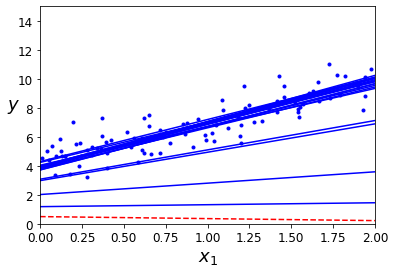

In [100]:
# For every epoch
for epoch in range(n_epochs):
    # Draw as many samples for SGD as there are samples in the training set
    for i in range(m):
        # For the first 20 samples in the first epoch
        if epoch == 0 and i < 20:
            # The prediciton using random initialised values of theta will be shown in red
            # For all others, show blue line
            y_predict = X_new_b.dot(theta)
            style ='b-' if i > 0 else 'r--'
            plt.plot(X_new, y_predict, style)
        
        # Generate index of sample to draw from training set to update weights
        random_index = np.random.randint(m)
        
        # Draw sample and its label
        x_i = X_b[random_index:random_index + 1]
        y_i = y[random_index:random_index + 1]
        
        # Compute the gradient using this sample
        gradients = 2 * x_i.T.dot(x_i.dot(theta) - y_i)
        
        # Calculate the learning rate as a function of the sample and epoch number
        # Later epochs and later samples will have lower learning rates
        eta = learning_schedule(epoch * m + i)
        
        # Update the params, append to theta_path_sgd
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)

# Superimpose scatterplot of training data
plt.plot(X, y, 'b.') # B dot. Not b. Need to make a scatter plot
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$y$', rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])

In [101]:
# What is the last value of theta calculated with SGD
theta

array([[4.21076011],
       [2.74856079]])

### Discussion
- The BGD algorithm took 1,000 iterations or iterated 1,000 times through the whole training set.
- SGD goes through the training set only 50 times before converging to a good solution.
    - 50 epochs or passes over the training set, and we already have convergence.
- Just because SGD iterates over `m` training samples **does not mean** that **all** samples in the training set will have been drawn at least once to update weights. Some samples may have been drawn more than once. Others may not have been drawn at all.
- If we want to ensure that all samples are drawn at least once, shuffle the data at each iteration in an epoch, and then generate a random index. However, this will converge more slowly. 

## SGD with `sklearn`

In [56]:
from sklearn.linear_model import SGDRegressor

The following `SGDRegressor` uses the mean-squared error as a loss function. It is set to iterate over the training set 1000 times, and will stop iterating as soon as magnitude of the loss between two iterations changes by less than 0.001. It does not implement any regularization, since `penalty` is `None`. The initial learning rate `eta0` is 0.1, and the learning schedule it uses to change the learning rate is different from the one we've implemented earlier. 

In [58]:
sgd_reg = SGDRegressor(loss='squared_loss', max_iter=1000, tol=1e-3, penalty=None, 
                      eta0=0.1, random_state=42)

In [59]:
# Why are we using y.ravel()
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.1, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=1000,
       n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
       random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [62]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

These values for `theta_0` and `theta_1` are both very close to the ones estimated by the normal equation. 

## Minibatch Gradient Descent

In [112]:
# Store weight updates for minibatch gradient descent to compare against other GDs
theta_path_mgd = []

In [113]:
n_iterations = 50

In [114]:
minibatch_size = 20

In [115]:
# Defining a function that will be used to update the learning rate 
t_0, t_1 = 200, 1000
def learning_schedule(t):
    return t_0 / (t + t_1)

In [116]:
# Initializing t
t = 0

In [117]:
np.random.seed(42)

In [118]:
# Random initialization of weights
theta = np.random.randn(2, 1)

In [119]:
for epoch in range(n_iterations):
    # Why are we using the permutation command here? Why not np.random.
    shuffled_indices = np.random.permutation(m)
    
    # Shuffle training samples and labels
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    
    # Iterate over the minibatch, use it to compute weight updates and gradients
    for i in range(0, m, minibatch_size):
        # Increment learning schedule counter variable
        t += 1
        x_i = X_b_shuffled[i : i + minibatch_size]
        y_i = y_shuffled[i : i + minibatch_size]
        
        # Denom is now the minibatch's size
        gradients = 2 / minibatch_size * x_i.T.dot(x_i.dot(theta) - y_i)
        
        # Update the learning rate for this iteration
        eta = learning_schedule(t)
        
        # Update the parameter weigths
        theta = theta - eta * gradients
        
        # Record the param updates
        theta_path_mgd.append(theta)

In [120]:
# What is the final value of theta derived from SGD?
theta

array([[4.25214635],
       [2.7896408 ]])

## Comparing Gradient Descent Variants

In [121]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

Saving figure  gradient_descent_paths_plot


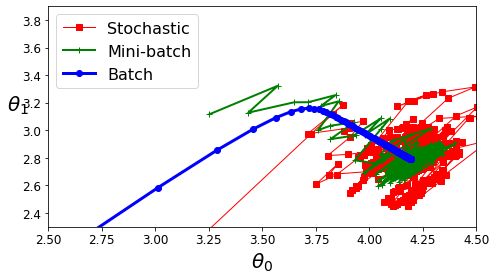

In [124]:
plt.figure(figsize=(7, 4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], 'r-s', 
        linewidth=1, label='Stochastic')
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], 'g-+', 
        linewidth=2, label='Mini-batch')
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], 'b-o', 
        linewidth=3, label='Batch')
plt.legend(loc='upper left', fontsize=16)
plt.xlabel(r'$\theta_0$', fontsize=20)
plt.ylabel(r'$\theta_1$', fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig('gradient_descent_paths_plot')